In [20]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)

# Data directory setup
DATA_DIR = "/content/"

# File paths
train_csv_file = os.path.join(DATA_DIR, "train.csv")
val_csv_file = os.path.join(DATA_DIR, "valid.csv")
test_csv_file = os.path.join(DATA_DIR, "test.csv")
ehr_pkl_file = os.path.join(DATA_DIR, "ehr_preprocessed_seq_by_day_cat_embedding.pkl")

# Load data
train_df = pd.read_csv(train_csv_file)
val_df = pd.read_csv(val_csv_file)
test_df = pd.read_csv(test_csv_file)

with open(ehr_pkl_file, 'rb') as f:
    ehr_data = pd.read_pickle(f)


In [21]:
def aggregate_admission_data(df, ehr_dict, aggregation, has_labels=True):
    """Aggregate features per admission with optional labels"""
    admission_ids = df['id'].unique()
    X = []
    y = [] if has_labels else None

    for adm_id in admission_ids:
        adm_rows = df[df['id'] == adm_id]
        adm_features = ehr_dict[adm_id]

        if aggregation == 'last':
            features = adm_features[-1]
        elif aggregation == 'mean':
            features = np.mean(adm_features, axis=0)
        elif aggregation == 'max':
            features = np.max(adm_features, axis=0)
        else:
            raise ValueError("Invalid aggregation method")

        X.append(features)

        if has_labels:
            y.append(adm_rows['readmitted_within_30days'].iloc[0])

    return np.array(X), (np.array(y) if has_labels else None)


In [22]:
# Process data for each aggregation method
# Last day aggregation
X_train_last, y_train_last = aggregate_admission_data(train_df, ehr_data["feat_dict"], 'last')
X_val_last, y_val_last = aggregate_admission_data(val_df, ehr_data["feat_dict"], 'last')
X_test_last = aggregate_admission_data(test_df, ehr_data["feat_dict"], 'last', has_labels=False)[0]

# Mean aggregation
X_train_mean, y_train_mean = aggregate_admission_data(train_df, ehr_data["feat_dict"], 'mean')
X_val_mean, y_val_mean = aggregate_admission_data(val_df, ehr_data["feat_dict"], 'mean')
X_test_mean = aggregate_admission_data(test_df, ehr_data["feat_dict"], 'mean', has_labels=False)[0]

# Max aggregation
X_train_max, y_train_max = aggregate_admission_data(train_df, ehr_data["feat_dict"], 'max')
X_val_max, y_val_max = aggregate_admission_data(val_df, ehr_data["feat_dict"], 'max')
X_test_max = aggregate_admission_data(test_df, ehr_data["feat_dict"], 'max', has_labels=False)[0]

print(f"Last Day - Train: {X_train_last.shape}, Val: {X_val_last.shape}, Test: {X_test_last.shape}")
print(f"Mean - Train: {X_train_mean.shape}, Val: {X_val_mean.shape}, Test: {X_test_mean.shape}")
print(f"Max - Train: {X_train_max.shape}, Val: {X_val_max.shape}, Test: {X_test_max.shape}")


Last Day - Train: (8234, 171), Val: (2788, 171), Test: (2741, 171)
Mean - Train: (8234, 171), Val: (2788, 171), Test: (2741, 171)
Max - Train: (8234, 171), Val: (2788, 171), Test: (2741, 171)


In [23]:
# Define clinically relevant features
clinically_relevant = [
    # Labs
    'Creatinine Blood', 'Hemoglobin Blood', 'Hematocrit Blood',
    'Potassium Blood', 'Sodium Blood', 'Glucose Blood',
    'Troponin T Blood', 'Platelet Count Blood', 'Eosinophils Blood',
    'pH Urine', 'pO2 Blood', 'pCO2 Blood', 'Anion Gap Blood',

    # ICD-10
    'I10-I16', 'N17-N19', 'J09-J18', 'E70-E88', 'I30-I52',
    'J40-J47', 'B20-B20',

    # Drugs
    'ANTICOAGULANTS', 'ANTIBIOTICS', 'IMMUNOSUPPRESSANTS',
    'ANTIINFLAM.TUMOR NECROSIS FACTOR INHIBITING AGENTS'
]


In [24]:
# Import libraries for feature analysis
from scipy.stats import pointbiserialr, chi2_contingency
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler

def analyze_zeros(ehr_data, feature_cols, threshold=0.5):
    """Analyze zero-value ratio in features"""
    all_zeros = []
    for feature_name, feature_idx in zip(feature_cols, range(len(feature_cols))):
        zeros_count = np.sum([np.sum(matrix[:, feature_idx] == 0) for matrix in ehr_data["feat_dict"].values()])
        total_values = sum([matrix.shape[0] for matrix in ehr_data["feat_dict"].values()])
        zero_ratio = zeros_count / total_values
        if zero_ratio > threshold:
            all_zeros.append((feature_name, zero_ratio))
    return pd.DataFrame(all_zeros, columns=["Feature", "Zero_Ratio"])


In [25]:
def compute_feature_associations(X, y, feature_names, ehr_data):
    """Compute statistical associations between features and target"""
    correlations = []
    p_values = []

    for i in range(X.shape[1]):
        if np.std(X[:, i]) == 0:
            correlations.append(0)
            p_values.append(1)
            continue

        if feature_names[i] in ehr_data["icd_cols"]:
            # Chi-squared for ICD features
            contingency = pd.crosstab(X[:, i], y)
            try:
                chi2, pval, _, _ = chi2_contingency(contingency)
                correlations.append(chi2)
                p_values.append(pval)
            except:
                correlations.append(0)
                p_values.append(1)
        else:
            # Point-biserial for continuous features
            corr, pval = pointbiserialr(X[:, i], y)
            correlations.append(corr)
            p_values.append(pval)

    return pd.DataFrame({
        'Feature': feature_names,
        'Association': correlations,
        'P-value': p_values
    })


In [26]:
def find_collinear_features(X, feature_names, threshold=0.8):
    """Identify feature pairs with correlation > threshold"""
    corr_matrix = pd.DataFrame(X).corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    collinear_pairs = [(feature_names[i], feature_names[j], corr_matrix.iloc[i,j])
                      for i,j in zip(*np.where(upper > threshold))]
    return pd.DataFrame(collinear_pairs, columns=['Feature1', 'Feature2', 'Correlation'])

def select_non_collinear_features(X, y, feature_names, ehr_data, clinically_relevant, corr_threshold=0.8):
    """Select non-collinear features while preserving clinically relevant ones"""
    # Standardize data for proper correlation calculation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Find all collinear pairs
    collinear_df = find_collinear_features(X_scaled, feature_names, corr_threshold)

    # Get feature importance scores
    importance = mutual_info_classif(X, y, random_state=42)
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

    features_to_keep = set(clinically_relevant)  # Always keep these

    # For non-clinical features, keep the more important one from collinear pairs
    for _, row in collinear_df.iterrows():
        f1, f2 = row['Feature1'], row['Feature2']

        # Skip if either is clinically relevant
        if f1 in clinically_relevant or f2 in clinically_relevant:
            continue

        # Keep feature with higher importance
        imp1 = importance_df.loc[importance_df['Feature'] == f1, 'Importance'].values[0]
        imp2 = importance_df.loc[importance_df['Feature'] == f2, 'Importance'].values[0]

        if imp1 > imp2:
            features_to_keep.add(f1)
        else:
            features_to_keep.add(f2)

    # Add any features not involved in collinearity
    all_features = set(feature_names)
    features_to_keep.update(all_features - set(collinear_df[['Feature1','Feature2']].values.flatten()))

    # Get indices of features to keep
    keep_indices = [i for i, f in enumerate(feature_names) if f in features_to_keep]
    remaining_features = [f for f in feature_names if f in features_to_keep]

    return keep_indices, remaining_features


In [27]:
def process_features(X_train, y_train, X_val, X_test, feature_names, ehr_data, clinically_relevant):
    """Process and filter features for a given dataset"""
    # Calculate standard deviations
    std_devs = np.std(X_train, axis=0)

    # Create a DataFrame for analysis
    std_df = pd.DataFrame({
        "Feature": feature_names,
        "Std_Dev": std_devs
    })

    # Calculate correlations
    correlations = []
    p_values = []

    for i in range(X_train.shape[1]):
        feature_name = feature_names[i]

        # Skip constant features
        if np.std(X_train[:, i]) == 0:
            correlations.append(0)
            p_values.append(1)
            continue

        # Use chi-squared for ICD features, point-biserial for others
        if feature_name in ehr_data["icd_cols"]:
            # Chi-squared test for binary ICD features
            contingency_table = pd.crosstab(X_train[:, i], y_train)
            try:
                chi2, pval, _, _ = chi2_contingency(contingency_table)
                correlations.append(chi2)  # Using chi2 statistic as effect size
                p_values.append(pval)
            except:
                correlations.append(0)
                p_values.append(1)
        else:
            # Point-biserial for continuous features
            corr, pval = pointbiserialr(X_train[:, i], y_train)
            correlations.append(corr)
            p_values.append(pval)

    # Create results DataFrame
    corr_df = pd.DataFrame({
        "Feature": feature_names,
        "Correlation": correlations,
        "P-value": p_values
    })

    # Sort by absolute correlation strength
    corr_df["Abs_Correlation"] = np.abs(corr_df["Correlation"])
    corr_df = corr_df.sort_values("Abs_Correlation", ascending=True)

    # Analyze zero-value ratio for each feature category
    demo_zero_df = analyze_zeros(ehr_data, ehr_data["demo_cols"])
    icd_zero_df = analyze_zeros(ehr_data, ehr_data["icd_cols"])
    lab_zero_df = analyze_zeros(ehr_data, ehr_data["lab_cols"])
    med_zero_df = analyze_zeros(ehr_data, ehr_data["med_cols"])

    # Combine all zero-value data
    zero_df = pd.concat([demo_zero_df, icd_zero_df, lab_zero_df, med_zero_df])

    # Merge zero-value data with std and correlation data
    combined_df = pd.merge(pd.merge(std_df, corr_df, on='Feature'), zero_df, on='Feature', how='left')

    # Define thresholds
    thresholds = {
        'zero_ratio': {
            'icd': 0.95,    # ICD codes often sparse
            'med': 0.95,    # Medications often sparse
            'lab': 0.95,    # Labs should rarely be zero
            'demo': 0.9     # Demographics rarely zero
        },
        'std_dev': 0.001,    # Only for continuous features
        'correlation': {
            'min_abs_corr': 0.001,
            'max_pvalue': 0.05
        }
    }

    # Categorize features
    feature_types = {
        'icd': ehr_data["icd_cols"],
        'med': ehr_data["med_cols"],
        'lab': ehr_data["lab_cols"],
        'demo': ehr_data["demo_cols"]
    }

    # Initialize storage
    features_to_remove = []

    # Check each feature type separately
    for ftype, cols in feature_types.items():
        for feature in cols:
            if feature not in combined_df['Feature'].values:
                continue

            row = combined_df[combined_df['Feature'] == feature].iloc[0]

            # Skip binary features for variance check
            check_variance = ftype not in ['icd']

            if ftype == 'icd':
                sig_threshold = 0.05  # Could use different threshold for chi-square
                effect_size = row['Correlation']  # Actually contains chi2 statistic
            else:
                sig_threshold = thresholds['correlation']['max_pvalue']
                effect_size = np.abs(row['Correlation'])

            if ('Zero_Ratio' in row and row['Zero_Ratio'] > thresholds['zero_ratio'][ftype]) and \
               (not check_variance or row['Std_Dev'] < thresholds['std_dev']) and \
               (effect_size < thresholds['correlation']['min_abs_corr']) and \
               (row['P-value'] > sig_threshold):
                if feature not in clinically_relevant:
                    features_to_remove.append(feature)

    # Get indices of features to remove
    all_features = ehr_data["feature_cols"]
    remove_indices = [i for i, feature in enumerate(all_features)
                     if feature in features_to_remove]

    # Function to remove features
    def remove_features(X, remove_indices):
        return np.delete(X, remove_indices, axis=1)

    # Apply feature removal
    X_train_filtered = remove_features(X_train, remove_indices)
    X_val_filtered = remove_features(X_val, remove_indices)
    X_test_filtered = remove_features(X_test, remove_indices)

    # Get remaining feature names
    remaining_features = [f for i, f in enumerate(all_features)
                         if i not in remove_indices]

    print(f"Filtered features from {X_train.shape[1]} to {X_train_filtered.shape[1]}")

    # Apply collinearity-based selection
    keep_indices, non_collinear_features = select_non_collinear_features(
        X_train_filtered, y_train, remaining_features, ehr_data, clinically_relevant, corr_threshold=0.7
    )

    # Apply final filtering
    X_train_final = X_train_filtered[:, keep_indices]
    X_val_final = X_val_filtered[:, keep_indices]
    X_test_final = X_test_filtered[:, keep_indices]
    final_feature_names = non_collinear_features

    print(f"Final features after collinearity removal: {X_train_final.shape[1]}")

    return X_train_final, X_val_final, X_test_final, final_feature_names


In [28]:
# Process features for each aggregation method
print("\nProcessing features for Last Day aggregation method:")
X_train_last_final, X_val_last_final, X_test_last_final, final_feature_names_last = process_features(
    X_train_last, y_train_last, X_val_last, X_test_last,
    ehr_data["feature_cols"], ehr_data, clinically_relevant
)

print("\nProcessing features for Mean aggregation method:")
X_train_mean_final, X_val_mean_final, X_test_mean_final, final_feature_names_mean = process_features(
    X_train_mean, y_train_mean, X_val_mean, X_test_mean,
    ehr_data["feature_cols"], ehr_data, clinically_relevant
)

print("\nProcessing features for Max aggregation method:")
X_train_max_final, X_val_max_final, X_test_max_final, final_feature_names_max = process_features(
    X_train_max, y_train_max, X_val_max, X_test_max,
    ehr_data["feature_cols"], ehr_data, clinically_relevant
)



Processing features for Last Day aggregation method:


<ipython-input-27-7ea7f4128bb8>:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  zero_df = pd.concat([demo_zero_df, icd_zero_df, lab_zero_df, med_zero_df])


Filtered features from 171 to 127
Final features after collinearity removal: 123

Processing features for Mean aggregation method:


<ipython-input-27-7ea7f4128bb8>:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  zero_df = pd.concat([demo_zero_df, icd_zero_df, lab_zero_df, med_zero_df])


Filtered features from 171 to 133
Final features after collinearity removal: 130

Processing features for Max aggregation method:


<ipython-input-27-7ea7f4128bb8>:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  zero_df = pd.concat([demo_zero_df, icd_zero_df, lab_zero_df, med_zero_df])


Filtered features from 171 to 119
Final features after collinearity removal: 119


In [29]:
# Import model training libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import KFold

def tune_hyperparameters(X_train, y_train, model_name):
    """Tune hyperparameters for AdaBoost model"""
    # Define hyperparameters to search
    learning_rates = [0.1, 0.25, 0.5, 1.0]
    max_depths = [1, 2, 3, 4, 5, 6]
    results = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    print(f"\nPerforming hyperparameter tuning for {model_name} model:")

    # K-Fold Cross Validation for hyperparameter tuning
    for lr in learning_rates:
        for depth in max_depths:
            adaboost_cv = AdaBoostClassifier(
                estimator=DecisionTreeClassifier(max_depth=depth, random_state=42),
                n_estimators=260,
                learning_rate=lr,
                random_state=42
            )

            fold_valid_accs = []
            for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
                X_tr, X_val_fold = X_train[train_idx], X_train[val_idx]
                y_tr, y_val_fold = y_train[train_idx], y_train[val_idx]

                adaboost_cv.fit(X_tr, y_tr)
                fold_pred = adaboost_cv.predict(X_val_fold)
                fold_acc = accuracy_score(y_val_fold, fold_pred)
                fold_valid_accs.append(fold_acc)

            mean_valid_acc = np.mean(fold_valid_accs)
            results.append({
                'learning_rate': lr,
                'max_depth': depth,
                'valid_accuracy': mean_valid_acc
            })

    # Find best hyperparameters
    results_df = pd.DataFrame(results)
    best_result = results_df.loc[results_df['valid_accuracy'].idxmax()]
    best_lr = best_result['learning_rate']
    best_depth = int(best_result['max_depth'])

    print(f"Best hyperparameters for {model_name} model:")
    print(f"  Learning Rate: {best_lr}")
    print(f"  Max Depth: {best_depth}")
    print(f"  Mean CV Validation Accuracy: {best_result['valid_accuracy']:.4f}")

    return best_lr, best_depth


In [30]:
def train_adaboost_model(X_train, y_train, X_val, y_val, model_name):
    """Train AdaBoost model and return model and performance metrics"""
    # Hyperparameter search
    best_lr, best_depth = tune_hyperparameters(X_train, y_train, model_name)

    # Train final model with best hyperparameters
    final_model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=best_depth, random_state=42),
        n_estimators=260,
        learning_rate=best_lr,
        random_state=42
    )

    final_model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = final_model.predict(X_val)
    y_val_prob = final_model.predict_proba(X_val)[:, 1]

    # Calculate performance metrics
    val_accuracy = accuracy_score(y_val, y_val_pred)
    fpr, tpr, _ = roc_curve(y_val, y_val_prob)
    auc_score = roc_auc_score(y_val, y_val_prob)

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_val, y_val_prob)
    pr_auc = auc(recall, precision)

    print(f"\n{model_name} Model Performance:")
    print(f"  Validation Accuracy: {val_accuracy:.4f}")
    print(f"  Validation AUC: {auc_score:.4f}")
    print(f"  Validation PR-AUC: {pr_auc:.4f}")

    # Show confusion matrix
    cm = confusion_matrix(y_val, y_val_pred)
    print(f"  Confusion Matrix:\n{cm}")

    return final_model, fpr, tpr, auc_score, val_accuracy, y_val_prob


In [31]:
# Train models for each aggregation method
print("\n" + "="*50)
print("Training Last Day aggregation model")
print("="*50)
last_model, last_fpr, last_tpr, last_auc, last_acc, last_probs = train_adaboost_model(
    X_train_last_final, y_train_last, X_val_last_final, y_val_last, "Last Day"
)

print("\n" + "="*50)
print("Training Mean aggregation model")
print("="*50)
mean_model, mean_fpr, mean_tpr, mean_auc, mean_acc, mean_probs = train_adaboost_model(
    X_train_mean_final, y_train_mean, X_val_mean_final, y_val_mean, "Mean"
)

print("\n" + "="*50)
print("Training Max aggregation model")
print("="*50)
max_model, max_fpr, max_tpr, max_auc, max_acc, max_probs = train_adaboost_model(
    X_train_max_final, y_train_max, X_val_max_final, y_val_max, "Max"
)



Training Last Day aggregation model

Performing hyperparameter tuning for Last Day model:
Best hyperparameters for Last Day model:
  Learning Rate: 0.25
  Max Depth: 6
  Mean CV Validation Accuracy: 0.8566

Last Day Model Performance:
  Validation Accuracy: 0.8562
  Validation AUC: 0.7524
  Validation PR-AUC: 0.5211
  Confusion Matrix:
[[2257   50]
 [ 351  130]]

Training Mean aggregation model

Performing hyperparameter tuning for Mean model:
Best hyperparameters for Mean model:
  Learning Rate: 0.1
  Max Depth: 3
  Mean CV Validation Accuracy: 0.8566

Mean Model Performance:
  Validation Accuracy: 0.8476
  Validation AUC: 0.7555
  Validation PR-AUC: 0.5013
  Confusion Matrix:
[[2285   22]
 [ 403   78]]

Training Max aggregation model

Performing hyperparameter tuning for Max model:
Best hyperparameters for Max model:
  Learning Rate: 0.1
  Max Depth: 5
  Mean CV Validation Accuracy: 0.8318

Max Model Performance:
  Validation Accuracy: 0.8350
  Validation AUC: 0.7123
  Validation PR

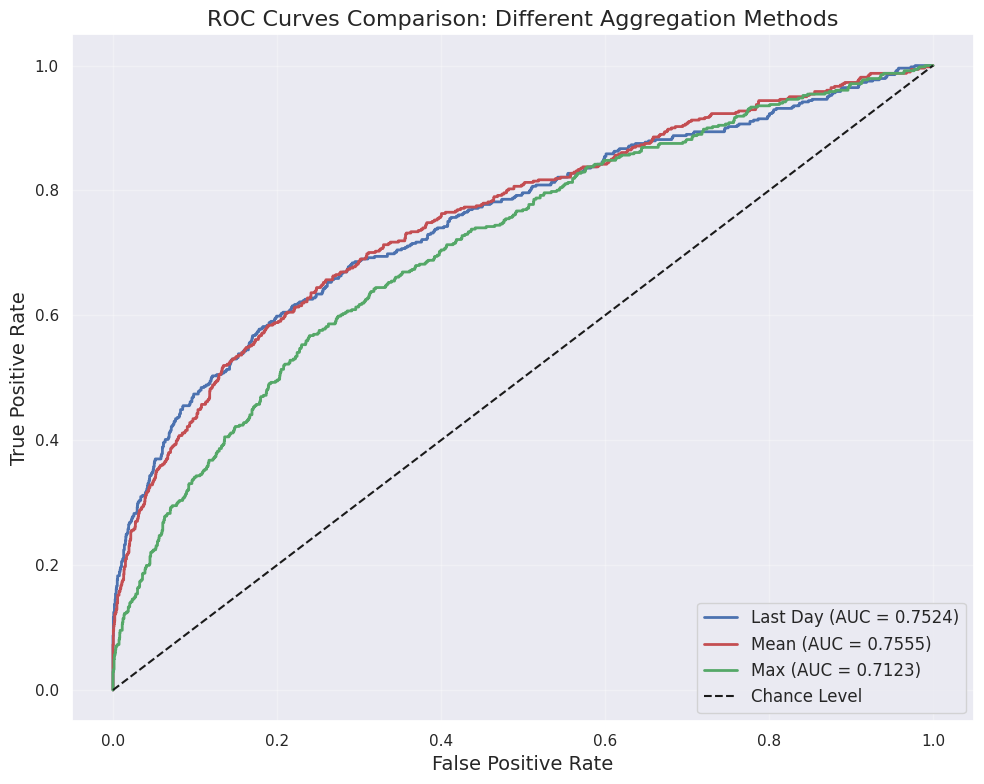

In [32]:
# Plot ROC curves for all three models in one figure
plt.figure(figsize=(10, 8))
plt.plot(last_fpr, last_tpr, 'b-', linewidth=2, label=f'Last Day (AUC = {last_auc:.4f})')
plt.plot(mean_fpr, mean_tpr, 'r-', linewidth=2, label=f'Mean (AUC = {mean_auc:.4f})')
plt.plot(max_fpr, max_tpr, 'g-', linewidth=2, label=f'Max (AUC = {max_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance Level')

# Add plot details
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves Comparison: Different Aggregation Methods', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save figure
plt.savefig(os.path.join(DATA_DIR, 'roc_curves_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()


In [33]:
# Determine best model based on AUC
methods = ["Last Day", "Mean", "Max"]
aucs = [last_auc, mean_auc, max_auc]
best_idx = np.argmax(aucs)
best_method = methods[best_idx]
best_auc = aucs[best_idx]

print(f"\nBest model based on validation AUC: {best_method} (AUC = {best_auc:.4f})")

# Select the best model and corresponding test data
if best_method == "Last Day":
    best_model = last_model
    X_test_final = X_test_last_final
elif best_method == "Mean":
    best_model = mean_model
    X_test_final = X_test_mean_final
else:  # Max
    best_model = max_model
    X_test_final = X_test_max_final



Best model based on validation AUC: Mean (AUC = 0.7555)


In [36]:
# Generate test predictions
y_test_pred = best_model.predict(X_test_final)
y_test_prob = best_model.predict_proba(X_test_final)[:, 1]

# Create submission file
test_ids_unique_df = test_df.drop_duplicates(subset='id', keep='first')
test_ids_unique = test_ids_unique_df['id']

if len(y_test_pred) == len(test_ids_unique):
    submission_df = pd.DataFrame({
        'id': test_ids_unique.values,
        'readmitted_within_30days': y_test_pred
    })

    # Save submission file
    submission_file_path = os.path.join(DATA_DIR, f'class_predictions_adaboost_{best_method.replace(" ", "_").lower()}.csv')
    submission_df.to_csv(submission_file_path, index=False)
    print(f"\nTest predictions saved successfully to: {submission_file_path}")
    print(f"Submission file head:")
    print(submission_df.head())
else:
    print(f"\nError: ID count mismatch between predictions ({len(y_test_pred)}) and test IDs ({len(test_ids_unique)})")



Test predictions saved successfully to: /content/class_predictions_adaboost_mean.csv
Submission file head:
                  id  readmitted_within_30days
0  16026764_21404901                     False
1  18463717_24608289                      True
2  16914073_28403863                     False
3  17119335_28722930                     False
4  10599715_20082646                     False


In [38]:
# Optional: Create ensemble model by averaging predictions
if len(set([X_val_last_final.shape[0], X_val_mean_final.shape[0], X_val_max_final.shape[0]])) == 1:
    print("\nCreating ensemble model by averaging the predictions of all three models...")

    # Average validation probabilities
    ensemble_val_probs = (last_probs + mean_probs + max_probs) / 3
    ensemble_val_preds = (ensemble_val_probs >= 0.5).astype(int)

    # Evaluate ensemble on validation set
    ensemble_acc = accuracy_score(y_val_last, ensemble_val_preds)  # All y_val sets are the same
    ensemble_auc = roc_auc_score(y_val_last, ensemble_val_probs)

    print(f"Ensemble Model - Validation Accuracy: {ensemble_acc:.4f}, AUC: {ensemble_auc:.4f}")

    # If ensemble is better than any individual model, use it for test predictions
    if ensemble_auc > best_auc:
        print("Ensemble model performs better than any individual model!")

        # Generate ensemble predictions for test set - FIXED VERSION
        # Use each model with its corresponding feature set
        ensemble_test_probs = (
            last_model.predict_proba(X_test_last_final)[:, 1] +
            mean_model.predict_proba(X_test_mean_final)[:, 1] +
            max_model.predict_proba(X_test_max_final)[:, 1]
        ) / 3
        ensemble_test_preds = (ensemble_test_probs >= 0.5).astype(int)

        # Create submission file for ensemble
        if len(ensemble_test_preds) == len(test_ids_unique):
            ensemble_submission_df = pd.DataFrame({
                'id': test_ids_unique.values,
                'readmitted_within_30days': ensemble_test_preds
            })

            ensemble_file_path = os.path.join(DATA_DIR, 'class_predictions_adaboost_ensemble.csv')
            ensemble_submission_df.to_csv(ensemble_file_path, index=False)
            print(f"Ensemble test predictions saved to: {ensemble_file_path}")



Creating ensemble model by averaging the predictions of all three models...
Ensemble Model - Validation Accuracy: 0.8547, AUC: 0.7754
Ensemble model performs better than any individual model!
Ensemble test predictions saved to: /content/class_predictions_adaboost_ensemble.csv


In [39]:
print("\n" + "="*50)
print("Summary of Results")
print("="*50)
print(f"Last Day Model - AUC: {last_auc:.4f}, Accuracy: {last_acc:.4f}")
print(f"Mean Model - AUC: {mean_auc:.4f}, Accuracy: {mean_acc:.4f}")
print(f"Max Model - AUC: {max_auc:.4f}, Accuracy: {max_acc:.4f}")
print(f"Best Model: {best_method}")
print("="*50)
print("Training and evaluation completed!")



Summary of Results
Last Day Model - AUC: 0.7524, Accuracy: 0.8562
Mean Model - AUC: 0.7555, Accuracy: 0.8476
Max Model - AUC: 0.7123, Accuracy: 0.8350
Best Model: Mean
Training and evaluation completed!
